# IE400 Project

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
points = pd.read_excel('data.xlsx', sheet_name='Points ').values
blocks = pd.read_excel('data.xlsx', sheet_name='Blocks').iloc[:, 0:4].values[1:]

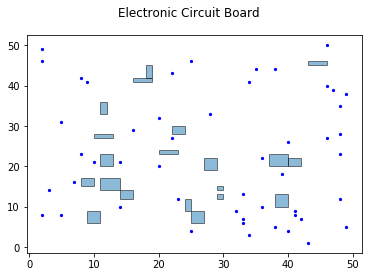

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.suptitle('Electronic Circuit Board')

ax.scatter(
    x=points[:,0],
    y=points[:,1],
    s=5,
    color='b',
    marker='o'
)

for block in blocks:
    ax.add_patch(
        patches.Rectangle(
            xy=(block[0], block[1]),  # point of origin.
            width=block[2],
            height=block[3],
            linewidth=1,
            edgecolor='black',
            alpha=0.5
        )
    )
    
plt.show()

In [4]:
min_x, min_y = min(points[:, 0]), min(points[:, 1])
max_x, max_y = max(points[:, 0]), max(points[:, 1])
num_points = len(points)

In [5]:
maze = np.zeros((max_x - min_x + 1, max_y - min_y + 1))
for block in blocks:
    for i in range(block[0] - min_x, block[0] + block[2] + 1 - min_x):
        for j in range(block[1] - min_y, block[1] + block[3] + 1 - min_y):
            maze[i, j] = 1

In [6]:
def check_cell(maze, is_visited, cell):
    return cell[0] >= 0 and cell[0] < maze.shape[0] and cell[1] >= 0 and cell[1] < maze.shape[1] \
        and not maze[cell[0]][cell[1]] == 1 and not is_visited[cell[0]][cell[1]]

In [7]:
def bfs(maze, source, dest):

    if maze[source[0], source[1]] == 1 or maze[dest[0], dest[1]] == 1:
        return float('inf'), None
    
    is_visited = [[False for _ in range(maze.shape[1])] for _ in range(maze.shape[0])]
    is_visited[source[0]][source[1]] = True 
    queue = [(source, 0, [])]
    
    while queue != []:
        
        curr = queue.pop(0)
        cell = curr[0]
        if cell[0] == dest[0] and cell[1] == dest[1]:
            return curr[1:]
        
        right_cell = [cell[0] + 1, cell[1]]
        if check_cell(maze, is_visited, right_cell):
            is_visited[right_cell[0]][right_cell[1]] = True
            queue.append((right_cell, curr[1] + 1, curr[2] + [right_cell]))
                         
        left_cell = [cell[0] - 1, cell[1]]
        if check_cell(maze, is_visited, left_cell):
            is_visited[left_cell[0]][left_cell[1]] = True
            queue.append((left_cell, curr[1] + 1, curr[2] + [left_cell]))
                         
        upper_cell = [cell[0], cell[1] + 1]
        if check_cell(maze, is_visited, upper_cell):
            is_visited[upper_cell[0]][upper_cell[1]] = True
            queue.append((upper_cell, curr[1] + 1, curr[2] + [upper_cell]))
                         
        lower_cell = [cell[0], cell[1] - 1]
        if check_cell(maze, is_visited, lower_cell):
            is_visited[lower_cell[0]][lower_cell[1]] = True
            queue.append((lower_cell, curr[1] + 1, curr[2] + [lower_cell]))
                         
    return float('inf'), None                                   

In [8]:
def manhattan_dist(point1, point2):
    return abs(point1[0] - point2[0]) + abs(point1[1] - point2[1])

In [9]:
cost_matrix = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(i, num_points):
        source = [points[i][0] - min_x, points[i][1] - min_y]
        dest = [points[j][0] - min_x, points[j][1] - min_y]
        path_len = bfs(maze, source, dest)[0]
        if path_len == manhattan_dist(source, dest):
            cost_matrix[i, j] = path_len
        else:
            cost_matrix[i, j] = float('inf')    

In [10]:
cost_flattened = cost_matrix[cost_matrix != 0].flatten('C')

In [11]:
file = open('cost_flattened.txt', 'w')
for cost in cost_flattened:
    if cost != float('inf'):
        file.write(str(int(cost)) + '\n')
    else:
        file.write('9999999999\n') # Some big number M  
file.close()

## Post Processing

In [12]:
cplex_str = "1 -> 14 -> 35 -> 26 -> 18 -> 22 -> 11 -> 12 -> 42 -> 30 -> 43 -> 4 -> 19 -> 38 -> 8 -> 9 -> 2 -> 23 -> 17 -> 25 -> 36 -> 24 -> 40 -> 13 -> 7 -> 41 -> 16 -> 37 -> 27 -> 49 -> 29 -> 15 -> 31 -> 21 -> 6 -> 10 -> 44 -> 3 -> 33 -> 39 -> 34 -> 32 -> 46 -> 45 -> 50 -> 20 -> 47 -> 5 -> 28 -> 48 -> "

In [13]:
visit_order_str = cplex_str.split(' -> ')[:-1]
visit_order = [int(node) - 1 for node in visit_order_str] 
visit_order += [visit_order[0]]

In [14]:
circuit = []
for i in range(num_points):
    source_point = points[visit_order[i]]
    source = [source_point[0] - min_x, source_point[1] - min_y]
    dest_point = points[visit_order[i + 1]]
    dest = [dest_point[0] - min_x, dest_point[1] - min_y]
    circuit.append(bfs(maze, source, dest)[1])

In [15]:
solution = []
for subpath in circuit:
    for node in subpath:
        solution.append([node[0] + min_x, node[1] + min_y])
solution = np.array(solution)

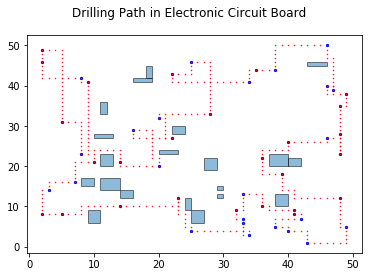

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.suptitle('Drilling Path in Electronic Circuit Board')

ax.scatter(
    x=points[:,0],
    y=points[:,1],
    s=5,
    color='b',
    marker='o'
)

ax.scatter(
    x=solution[:,0],
    y=solution[:,1],
    s=1,
    color='r',
    marker='.'
)

for block in blocks:
    ax.add_patch(
        patches.Rectangle(
            xy=(block[0], block[1]),  # point of origin.
            width=block[2],
            height=block[3],
            linewidth=1,
            edgecolor='black',
            alpha=0.5
        )
    )

plt.show()